# Installs & Imports

In [1]:
!pip install qiskit -q
!pip install qiskit-machine-learning -q

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

from matplotlib import pyplot as plt
import numpy as np

     |████████████████████████████████| 4.8 MB 4.7 MB/s 
     |████████████████████████████████| 19.2 MB 1.2 MB/s 
     |████████████████████████████████| 240 kB 63.4 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 106 kB 64.8 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 37.5 MB 90.9 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 943 kB 65.8 MB/s 
     |████████████████████████████████| 4.1 MB 71.6 MB/s 
     |████████████████████████████████| 1.9 MB 77.2 MB/s 
     |████████████████████████████████| 112 kB 84.8 MB/s 
     |████████████████████████████████| 152 kB 4.7 MB/s 
     |████████████████████████████████| 95 kB 5.4 MB/s 


In [2]:
!pip install pylatexenc -q
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

     |████████████████████████████████| 162 kB 5.2 MB/s 


# Variational Quantum Classifier via Qiskit-Machine-Learning

## Implementation - 2D Data

Text(0, 0.5, 'Feature 2')

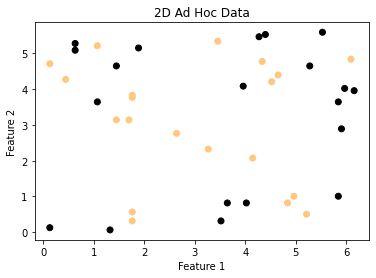

In [3]:
seed = 1376
algorithm_globals.random_seed = seed

# Use ad hoc data set for training and test data
feature_dim = 2  # dimension of each data point
training_size = 20
test_size = 10

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)

# Visualizing Ad Hoc Data
plt.scatter(np.array(training_features)[:, 0], np.array(training_features)[:, 1], 
            c=np.argmax(np.array(training_labels), axis=1), cmap='copper')
plt.title("2D Ad Hoc Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")



In [4]:
# ZZFeatureMap creates a quantum circuit out of the classical data
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

print(feature_map.decompose().draw())


     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘


In [5]:
# TwoLocal circuit

'''
From Qiskit Documentation:
The two-local circuit is a parameterized circuit consisting of alternating rotation layers 
and entanglement layers. The rotation layers are single qubit gates applied on all qubits. 
The entanglement layer uses two-qubit gates to entangle the qubits according to a strategy 
set using entanglement. Both the rotation and entanglement gates can be specified as string 
(e.g. 'ry' or 'cx'), as gate-type (e.g. RYGate or CXGate) or as QuantumCircuit 
(e.g. a 1-qubit circuit or 2-qubit circuit).
'''

# We assume that the solution takes the form of the 'ansatz'

ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
print(ansatz.decompose().draw())

     ┌──────────┐┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─■─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─■─┤ Ry(θ[8]) ├»
     ├──────────┤├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├─■─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─■─┤ Ry(θ[9]) ├»
     └──────────┘└──────────┘   └──────────┘└──────────┘   └──────────┘»
«     ┌───────────┐   ┌───────────┐┌───────────┐
«q_0: ┤ Rz(θ[10]) ├─■─┤ Ry(θ[12]) ├┤ Rz(θ[14]) ├
«     ├───────────┤ │ ├───────────┤├───────────┤
«q_1: ┤ Rz(θ[11]) ├─■─┤ Ry(θ[13]) ├┤ Rz(θ[15]) ├
«     └───────────┘   └───────────┘└───────────┘


In [6]:
# COBYLA = Constrained Optimization By Linear Approximation optimizer. 
# COBYLA assumes the derivative of the objective function isn't known

# VQC = Variational Quantum Classifier
# 1 - Feature Map - Load data into quantum system
# 2 - Ansatz - Variational quantum circuit - a quantum circuit that needs certain parameters (trained via ML)
# 3 - Measure an n (classical) bit output, and convert to a label (e.g. binary)
# 4 - Optimization (may not always be gradient-based). In this case, COBYLA

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
)

vqc.fit(training_features, training_labels)

score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")



Testing accuracy: 0.95


## Higher-Dimensional Data

In [ ]:
# Ad Hoc Data doesn't support feature dims > 3

feature_dim = 3  # dimension of each data point
training_size = 100
test_size = 50

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)


In [ ]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)


In [ ]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
)

vqc.fit(training_features, training_labels)

score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.53


# Quantum CNN

Extremely useful: https://qiskit.org/documentation/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

## Intro - CNNs

Convolutional neural networks (CNNs) are deep learning architectures that are based on a unit called a convolution

![alt text](https://anhreynolds.com/img/cnn.png)

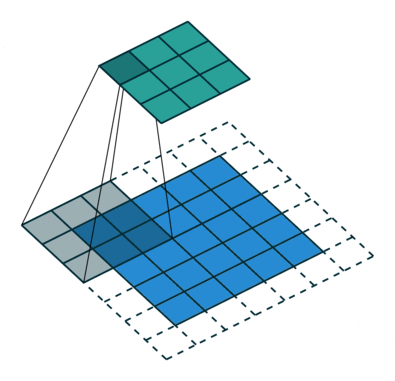

## Classical Example - VGG16

![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)


## Quantum CNN Architecture

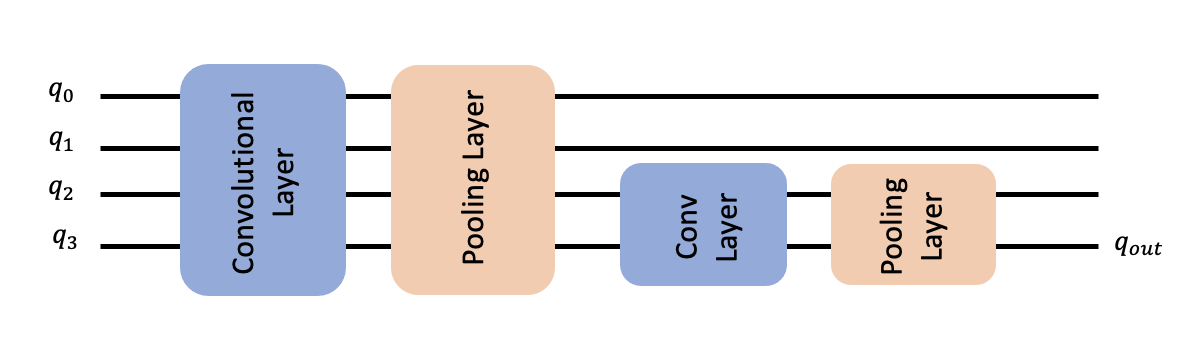

## Data Generation

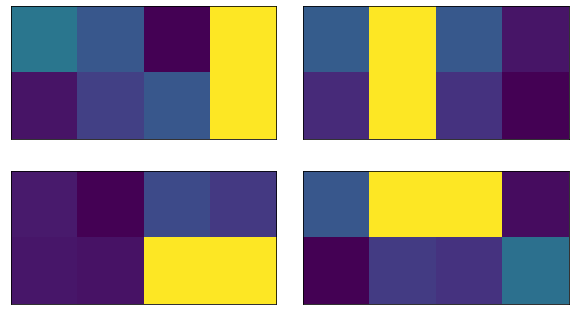

In [7]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

## QCNN Implementation

In [ ]:
# Steps
# 1 - Feature Map - Load data into quantum system
# 2 - Ansatz - Variational quantum circuit - a quantum circuit that needs certain parameters (trained via ML)
# 3 - Measure an n (classical) bit output, and convert to a label (e.g. binary)
# 4 - Optimization (may not always be gradient-based). In this case, COBYLA

# COBYLA = Constrained Optimization By Linear Approximation optimizer. 
# COBYLA assumes the derivative of the objective function isn't known


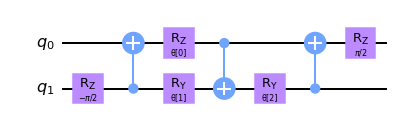

In [8]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

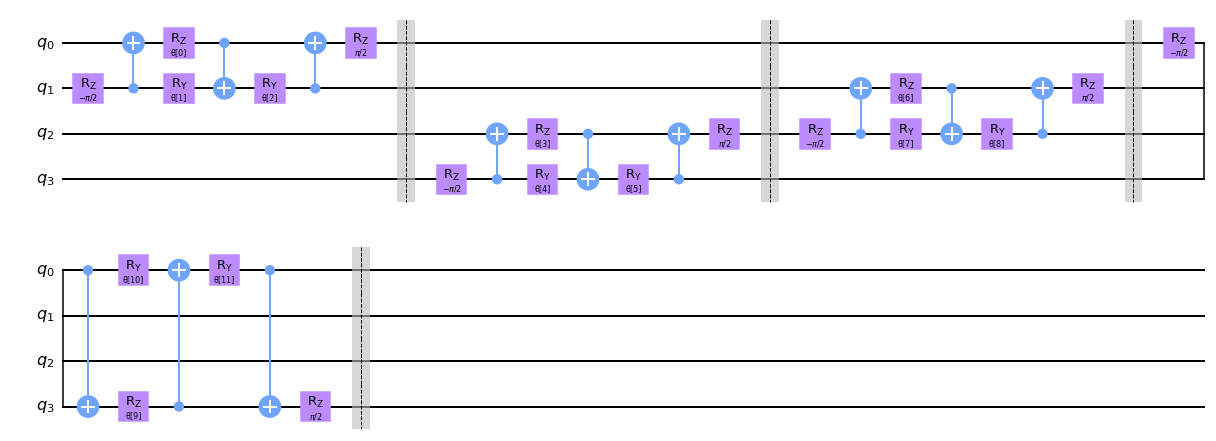

In [9]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

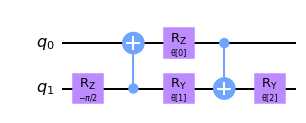

In [10]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")


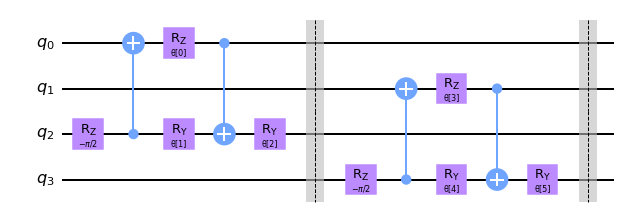

In [11]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

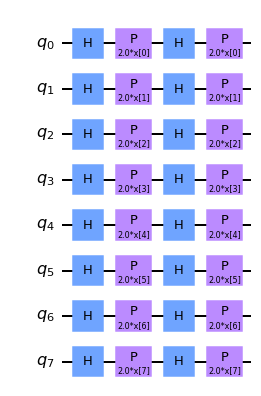

In [12]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

In [13]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

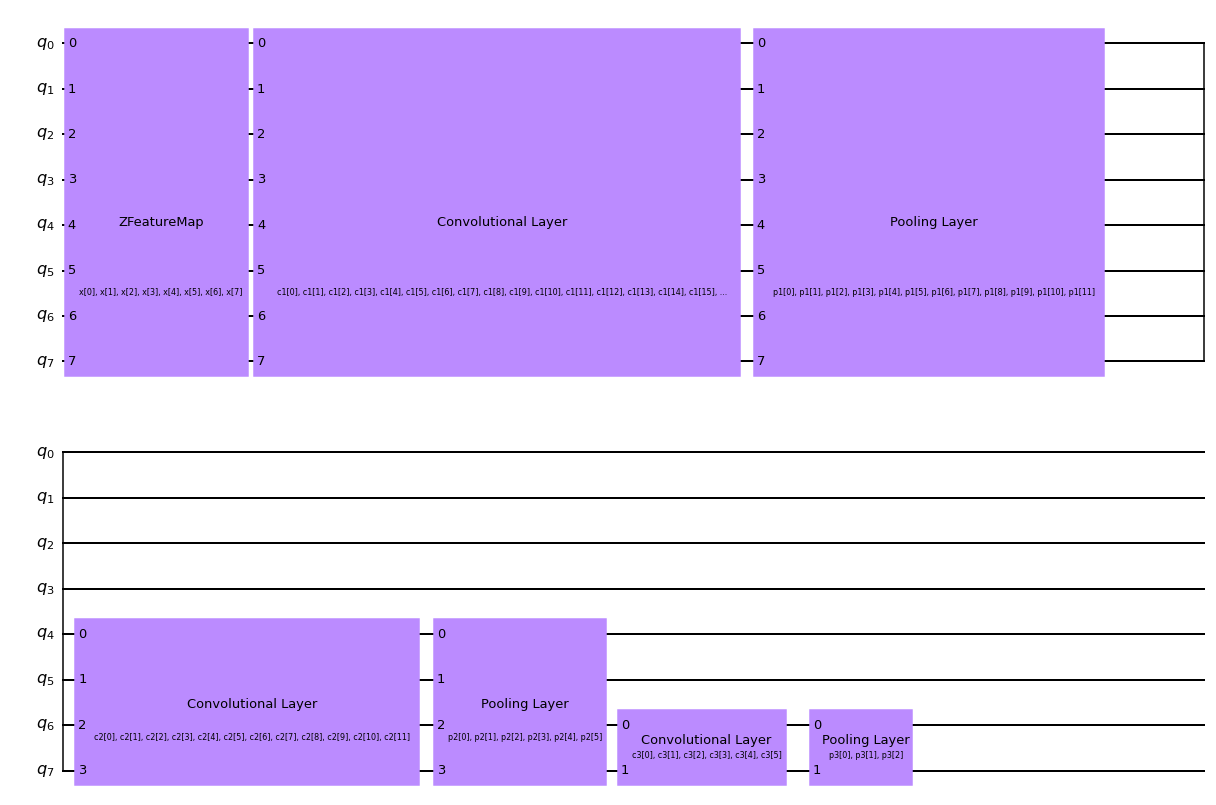

In [ ]:
circuit.draw("mpl")


In [14]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp '/content/drive/MyDrive/Quantum Computing/11_qcnn_initial_point.json' ./

Mounted at /content/drive


In [16]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

## Visualize Training!

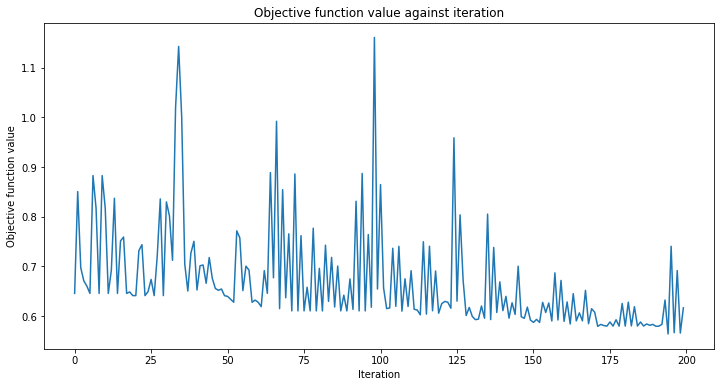

Accuracy from the train data : 91.43%


In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

## Testing the QCNN

Accuracy from the test data : 80.0%


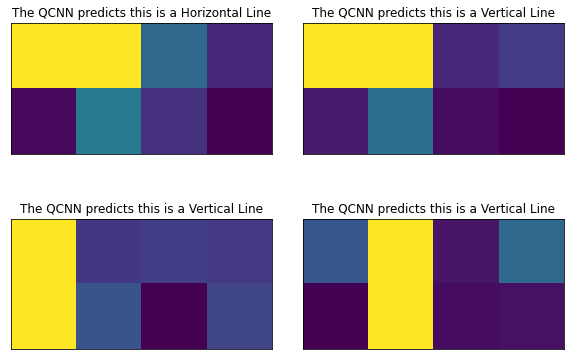

In [ ]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

# Support Vector Machine via Qiskit

## Intro - SVMs

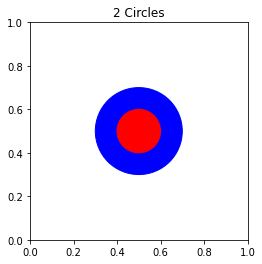

Can be mapped into a 1D space (x^2 + y^2) via a kernel for a simple decision boundary


In [17]:
figure, axes = plt.subplots()
draw1 = plt.Circle((0.5, 0.5), 0.2, color='b')

draw2 = plt.Circle((0.5, 0.5), 0.1, color='r')

axes.set_aspect(1)
axes.add_artist(draw1)
axes.add_artist(draw2)
plt.title('2 Circles')
plt.show()

print('Can be mapped into a 1D space (x^2 + y^2) via a kernel for a simple decision boundary')

## Implementation - 2D Data
See https://www.youtube.com/watch?v=OKbcJCUx6xA&list=PLOFEBzvs-VvrhKYASly1BXo1AdPyoCsor&index=6